In [58]:
# Source: https://www.youtube.com/watch?v=TCH_1BHY58I&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=3
# Paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf 

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [59]:
words = open('./data/names.txt').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [60]:
characters = sorted(list(set(''.join(words))))
stoi = {c: i+1 for i, c in enumerate(characters)}
stoi['.'] = 0
itos = {i: c for c, i in stoi.items()}

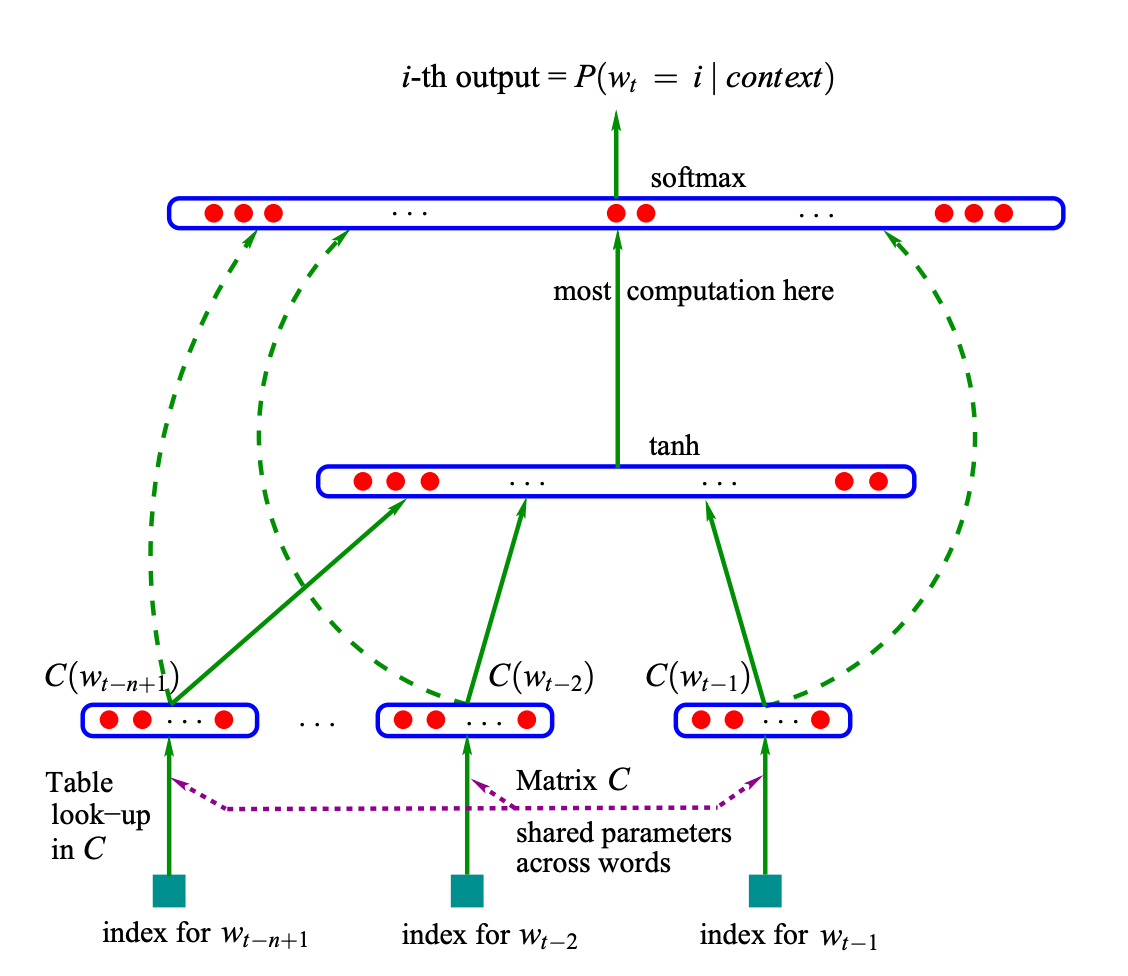

In [61]:
# We are going to build this neural network from original paper (ignore dot lines from diagram). And also instead of predicting next word in a sentence we are going to predict next character in a word.  
Image(filename='./images/mlp-architecture.png') 

In [62]:
# First we need to prepare dataset. We are going to use 3 characters to predict next character (as from diagram).
block_size = 3
X, Y = [], []
for w in words[:5]:
    print(w)
    context = [0] * block_size # [0, 0, 0] for block_size 3
    for c in w + '.':
        ix = stoi[c]
        X.append(context)
        Y.append(ix)
        print(''.join([itos[i] for i in context]), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.Tensor(X).long()
Y = torch.Tensor(Y).long()

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [63]:
# We also need a lookup table. In original table they put 17000 words into 30 dimensional space. We only have 27 characters, so lets put them into 2 dimensional space.

In [64]:
C = torch.randn((27, 2))
C

tensor([[ 0.8395,  1.6651],
        [ 2.2163,  0.5497],
        [ 0.1061,  0.9020],
        [ 0.2961,  1.3819],
        [-0.0283, -0.9771],
        [ 0.5224, -0.4047],
        [ 0.6519,  1.4988],
        [ 0.6257, -0.1709],
        [ 1.9759, -0.7894],
        [ 1.0048, -0.5575],
        [-0.9698, -0.7189],
        [ 1.6656, -0.0849],
        [-0.2993,  1.1932],
        [-1.0349, -1.2342],
        [ 0.8612,  0.8054],
        [ 0.2855,  2.5056],
        [ 0.5670,  1.7479],
        [-0.7047,  1.0964],
        [ 1.0719,  0.3796],
        [-1.0395,  1.6251],
        [ 0.2591, -1.7471],
        [ 0.7123,  1.5446],
        [ 0.9535, -1.2255],
        [-1.3858, -2.6814],
        [-2.0591, -0.9784],
        [-1.2716,  0.7825],
        [ 1.2289, -0.3597]])

In [65]:
# There are 2 ways not to encode our characters.
print(C[5]) # Just take 5th row from our lookup table.
print(F.one_hot(torch.tensor(5), num_classes=27).float() @ C) # Encode character into vector with only one 1 and all other 0s. And apply matrix multiplication with our lookup table.  
# Both of them give the same result, in our case it's easier to move forward without one hot encoding.

tensor([ 0.5224, -0.4047])
tensor([ 0.5224, -0.4047])


In [66]:
# To embed all our data, we cna do it simply like that. Pytorch support indexing not only with integers, but lists and tensors (including multidimensional).
emb = C[X]
emb.shape # The table where for each example (32) we have all characters (3) encoded into n-dimensional space (2).
# This is out first (input) linear layer.

torch.Size([32, 3, 2])

In [67]:
# Now let's build the second layer
neurons_count = 100 # Number of neurons in our hidden layer

W1 = torch.randn((6, neurons_count)) # We have 6 inputs (3 characters * 2 dimensions) and 100 neurons in our hidden layer.
b1 = torch.randn(neurons_count)

In [68]:
# Now we would like to do something like this
# emb @ W1 + b1
# But we can't do it, we can't multiply 3D tensor with 2D tensor. We need to reshape our emb tensor to 2D tensor. [32, 3, 2] -> [32, 6], we want to concatenate all 3 characters with 2 dimensions into one tensor.
h = emb.view(emb.shape[0], 6) @ W1 + b1
print(h.shape) # We have 32 examples and 100 neuron activations for each example.

h = torch.tanh(h) # We are going to use tanh activation function. [-1, 1]

torch.Size([32, 100])


In [69]:
# And now let's build 3rd (output) layer
W2 = torch.randn((neurons_count, 27)) # We have 100 neurons in our hidden layer and 27 neurons in our output layer.
b2 = torch.randn(27)

In [70]:
logits = h @ W2 + b2
print(logits.shape) # We have 32 examples and 27 neurons in our output layer.
counts = logits.exp()# [-inf, inf] -> [0, inf] 
probs = counts / counts.sum(1, keepdim=True) # [0, inf] -> [0, 1] Probabilities

torch.Size([32, 27])


In [79]:
# Let's see current predictions (the network is not trained yet), we want each number to be close to 1.
pred = probs[torch.arange(32), Y]
print(pred)
loss = -torch.log(pred).mean()
print(loss)

tensor([3.5158e-08, 1.6149e-07, 2.2234e-02, 1.3351e-08, 6.3722e-05, 6.0820e-08,
        2.3914e-10, 5.8987e-05, 1.2712e-10, 6.1384e-11, 2.7687e-07, 1.8854e-10,
        7.3520e-10, 3.9386e-15, 3.8686e-09, 3.2318e-09, 8.7169e-07, 4.9996e-13,
        2.1710e-09, 1.5548e-02, 1.8076e-10, 6.4695e-13, 3.0765e-04, 1.4023e-09,
        2.8426e-06, 2.5581e-14, 8.3164e-09, 4.1326e-04, 1.0241e-04, 6.8291e-05,
        1.7200e-07, 1.1828e-08])
tensor(17.4454)


In [87]:
# Let's rewrite everything to be more clear
# Dataset
block_size = 3
X, Y = [], []
for w in words:
    context = [0] * block_size # [0, 0, 0] for block_size 3
    for c in w + '.':
        ix = stoi[c]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.Tensor(X).long()
Y = torch.Tensor(Y).long()

# Parameters
neurons_count = 100
C = torch.randn((27, 2))
W1 = torch.randn((6, neurons_count))
b1 = torch.randn(neurons_count)
W2 = torch.randn((neurons_count, 27))
b2 = torch.randn(27)
params = [C, W1, b1, W2, b2]
print("Parameters:", sum([p.numel() for p in params]))
for p in params:
    p.requires_grad_()

Parameters: 3481


In [112]:
for _ in range(10000):
    # On whole dataset it's going to be very slow, so we need batching
    ix = torch.randint(0, X.shape[0], (32,)) # Randomly select 32 examples
    # Although now it won't be a complete exact gradient, it's onl ya good enough approximation, in practice it is much better to take much more steps with approximate gradient, then to take a few steps with exact gradient.
    
    # Forward pass
    emb = C[X[ix]]
    h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # probs = counts / counts.sum(1, keepdim=True)
    # pred = probs[torch.arange(X.shape[0]), Y]
    # loss = -torch.log(pred).mean()
    loss = F.cross_entropy(logits, Y[ix]) # It's the same as above, but more efficient (both forward and backward pass) and more numerically stable (protection from overflow).
    
    # Backward pass
    for p in params:
        p.grad = None
    loss.backward()
    
    # Update parameters
    learning_rate = 0.1 # Apply a few iterations of 0.1 and then a few iterations of 0.01, this is called learning rate decay.
    for p in params:
        p.data -= learning_rate * p.grad

In [114]:
emb = C[X]
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y) 
print(loss.item()) # It's already better than our bigram model results ~2.5

2.294705390930176


In [115]:
# Although we said it's better, it's not really true, it's better on this exact dataset, but we need to test it on a different dataset to understand if it's really better. That's why we need to split our dataset into training (~80%, train the parameters), validation (~10% train hyperparameters e.g. learning rate, dimensions of lookup table, neurons count in hidden layers, etc) and testing datasets (~10% to evaluate the model).

In [116]:
# If loss we calculate from training and dev datasets are equal, it means we are not overfitting (model is not powerful enough to just memorize the training data) and we expect to increase performance if we increase the number of parameters.

In [118]:
# Sampling
for _ in range(20):
    name = ''
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        next_char = torch.multinomial(probs, num_samples=1).item()
        if next_char == 0:
            break
        name += itos[next_char]
        context = context[1:] + [next_char]
    print(name)


jayluwarele
avepol
juckeloniei
kavidkcorien
julia
kie
karilorhic
kamdieu
dor
kria
brithilead
aarsebereriemacier
makoly
ezirera
delleighon
aja
jedaon
lawathanmmi
anualelynna
nolani
